In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

Модель Q обучения

In [2]:
from lerning import QLerning

Импорт моделей:\
__Deck__ - модель колоды (создание колоды и манипуляции над ней);\
__SimpleModel__ - простая игра, размерность матрицы полезности 180x2 (18 состояний на руке игрока, 10 состояний начальной карты диллера, 2 возможных действия);\
__DoubleModel__ - игра с возможностью удвоения, размерность матрицы полезности 180x3 (18 состояний на руке игрока, 10 состояний начальной карты диллера, 3 возможных действия);\
__СountingModel__ - игра с возможностью удвоения и подсчёта карт, размерность матрицы полезности 738x3 (18 состояний на руке игрока, 41 состояние колоды, 3 возможных действия);

In [3]:
from models import Deck, SimpleModel, DoubleModel, СountingModel

In [53]:
def convert_to_char(matrix):
    """Конвертация числовой матрицы в символьную"""
    matr = []
    for i in range(matrix.shape[0]):
        row = []
        for j in range(matrix.shape[1]):
            if matrix[i,j] == 0:
                row.append("Stand")
            if matrix[i,j] == 1:
                row.append("Hit")
            if matrix[i,j] == 2:
                row.append("Double")
            if matrix[i,j] == 3:
                row.append("Split")
        matr.append(row)
    return np.array(matr)

def heatmap_plot(data, dict_var):
    """Отрисовка матрицы действий по матрице полезности"""
    data_labels = convert_to_char(data)
    
    x_len = len(dict_var["x_data_labels"])
    y_len = len(dict_var["y_data_labels"])
    
    fig, ax = plt.subplots(figsize=dict_var["figsize"])
    im = ax.imshow(data, cmap="Set1")
    
    ax.set_xticks(np.arange(x_len))
    ax.set_yticks(np.arange(y_len))

    ax.set_xticklabels(dict_var["x_data_labels"])
    ax.set_yticklabels(dict_var["y_data_labels"])
    
    plt.axis([-0.5, x_len - 0.5, -0.5, y_len - 0.5])

    for i in range(y_len):
        for j in range(x_len):
            text = ax.text(j,
                           i,
                           data_labels[i, j],
                           ha="center",
                           va="center",
                           color="w",
                          )
            
    ax.set_title(dict_var["title"])
    ax.set_xlabel(dict_var["xlabel"])
    ax.set_ylabel(dict_var["ylabel"])
    plt.show()


## Часть 1. Простая стратегия

Простая стратегия: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit.

In [4]:
env = gym.make('Blackjack-v0', natural=False)

def model_(treshhold, n_model):
    """
    Подсчет ожидания среднего выигрыша
        treshhold - порог очков в руке игрока до которого игрок берет дополнительные карты
        n_model - количество партий игры
        """
    sum_ = 0
    
    for i in range(0,n_model):
        state = env.reset()
        done = False
        while not done:
            if state[0] < treshhold:
                new_state, reward, done, _= env.step(1)
                state = new_state
            else:
                new_state, reward, done, _= env.step(0)

        sum_ += reward
    return sum_/n_model

In [5]:
out = []
range_ = np.arange(19,22)
for i in tqdm(range_):
    out.append(model_(i, 100000))

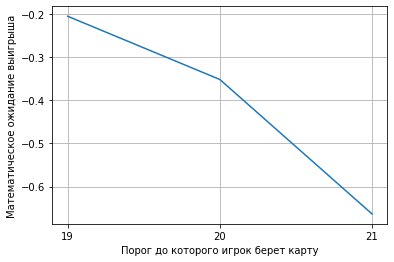

In [6]:
fig, ax = plt.subplots()
ax.plot(range_, np.array(out))
ax.set_xticks(range_)
ax.set_title("")
ax.set_xlabel("Порог до которого игрок берет карту")
ax.set_ylabel("Математическое ожидание выигрыша")
ax.grid()

Обучение модели простой игры (180 состояний, 2 действия)

In [7]:
model_1 = SimpleModel(multiproc_game=False)
ql_1 = QLerning(model_1, alpha=0.1, gamma=0.5, epsilon=0.00)

<IPython.core.display.Javascript object>


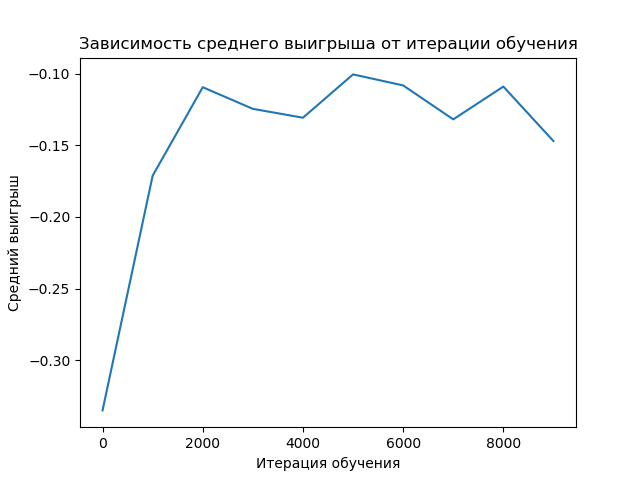

value from best iter = -0.3351
value from best iter = -0.17125
value from best iter = -0.10945
value from best iter = -0.1005

all time best= -0.1005


In [8]:
%matplotlib notebook
ql_1.traning_model(n_train = 10000,
                   show_fit = True,
                   delta_show = 1000, 
                   n_games = 10000)

Средний выигрыш на последней итерации обучения

In [26]:
ql_1.get_mean_reward()

-0.134

Матрица полезности на последней итерации обучения

In [9]:
ql_1.get_matrix_q()

array([[ 0.38402989,  0.00669598],
       [ 0.27525229,  0.28819936],
       [ 0.59301599,  0.71038067],
       [ 0.00770974, -0.01952761],
       [ 0.1424279 , -0.03175875],
       [-0.15626822,  0.07194327],
       [ 0.15596722,  0.17712659],
       [-0.0033783 ,  0.12118291],
       [-0.62968872, -0.04278289],
       [-0.33750305, -0.2747541 ],
       [-0.76142012, -0.58224749],
       [-0.62549664, -0.08596343],
       [-0.33033171, -0.87783933],
       [-0.57006229, -0.81434344],
       [ 0.46456623, -0.70782487],
       [-0.13458324, -0.11901335],
       [ 0.33779926,  0.35286722],
       [ 1.1273793 ,  0.28522078],
       [ 0.63068857,  0.5981411 ],
       [ 0.02151024,  0.36222656],
       [ 0.19991118,  0.41002404],
       [-0.10369638,  0.14478325],
       [-0.00322846,  0.194916  ],
       [ 0.04004498,  0.15381363],
       [-0.08959707,  0.09681089],
       [-0.17583914,  0.2828018 ],
       [-0.41337207, -0.54652158],
       [-0.43792872, -0.73784172],
       [-0.51430023,

In [43]:
dict_var_1 = {"x_data_labels":list(map(str, np.arange(4, 22))),
              "y_data_labels":['A', '2', '3', '4', '5', '6', '7', '8', '9', 'J,Q,K'],
              "figsize":(12,8),
              "title":"Стратегии игры",
              "xlabel":"Сумма карт на руках игрока",
              "ylabel":"Первая карта на руках диллера",
              }

Получение матрицы полезности

In [13]:
data_1 = model_1.get_matrix_actions(ql_1.get_matrix_q(), num_col = 18)

Интерпретация матрицы полезности

<IPython.core.display.Javascript object>


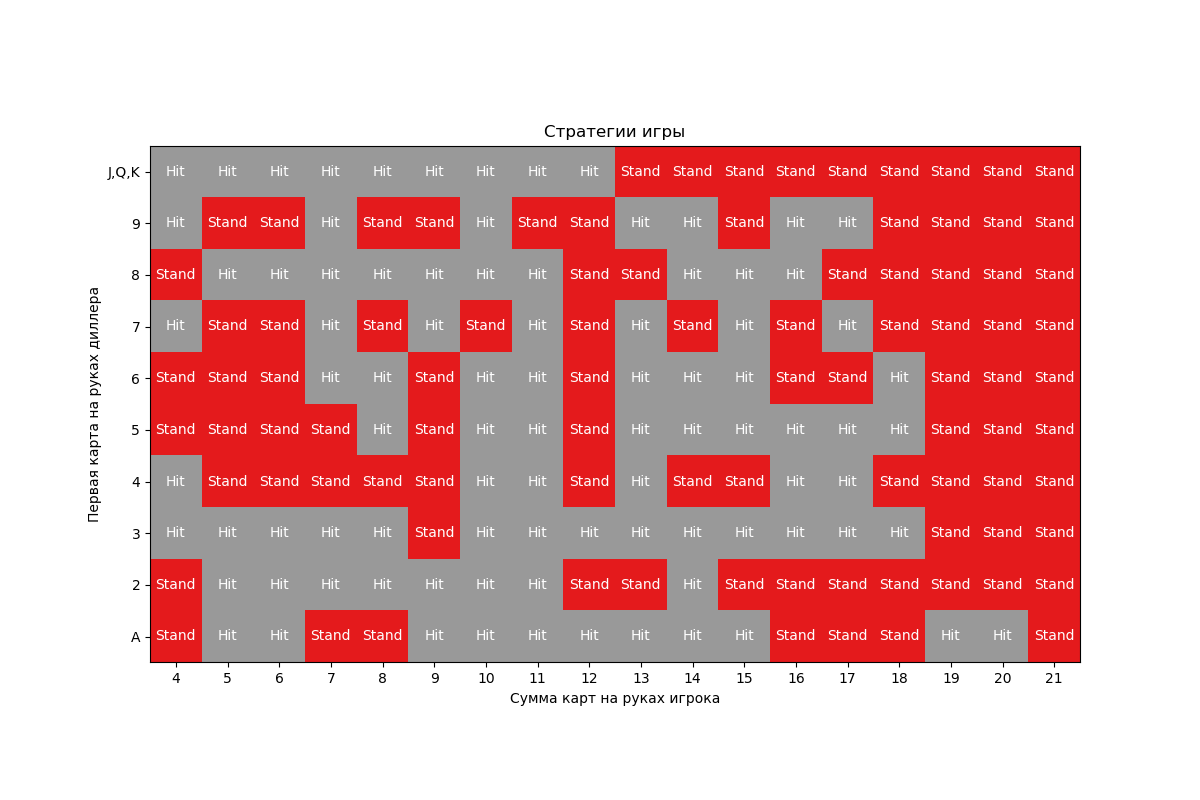

In [20]:
heatmap_plot(data_1, dict_var_1)

## Часть 2. Стратегия с удвоением

Обучение модели простой игры с возможностью удвоения (180 состояний, 3 действия)

In [23]:
model_2 = DoubleModel(multiproc_game=False)
ql_2 = QLerning(model_2, alpha=0.1, gamma=0.5, epsilon=0.00)

<IPython.core.display.Javascript object>


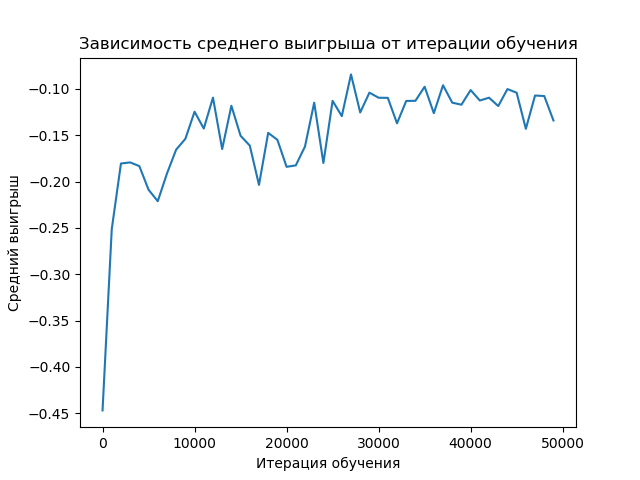

value from best iter = -0.4469
value from best iter = -0.25135
value from best iter = -0.18045
value from best iter = -0.17925
value from best iter = -0.1654
value from best iter = -0.1538
value from best iter = -0.1245
value from best iter = -0.1093
value from best iter = -0.08425

all time best= -0.08425


In [24]:
%matplotlib notebook
ql_2.traning_model(n_train = 50000,
                  show_fit = True,
                  delta_show = 1000, 
                  n_games = 10000)

Средний выигрыш на последней итерации обучения

In [37]:
ql_2.get_mean_reward()

-0.12485

Матрица полезности на последней итерации обучения

In [28]:
ql_2.get_matrix_q()

array([[ 1.05041318e-01,  3.09760640e-02,  4.50372577e-01],
       [-3.79483312e-02,  7.20373310e-03, -6.09005266e-01],
       [-1.91362285e-01, -9.49444797e-02,  2.87850444e-03],
       [-3.10537227e-01, -5.34882309e-02, -4.17142990e-01],
       [-3.53083233e-01, -4.41231285e-02, -9.12201606e-01],
       [-2.21721053e-01,  5.10870123e-02, -6.89968595e-01],
       [-1.97374504e-01,  5.20828612e-02, -9.42114494e-03],
       [ 9.75790003e-03,  1.06249264e-01,  1.66935581e-01],
       [-6.95734616e-01, -8.97790484e-01, -9.76899292e-01],
       [-6.12158758e-01,  5.96279625e-03, -4.12090714e-02],
       [-3.23109751e-01, -9.83598395e-01, -1.34541244e-01],
       [-3.37602419e-01,  3.17009534e-04,  8.84440422e-02],
       [-3.46743321e-01, -9.94975317e-01, -9.95478470e-01],
       [-2.84660112e-01, -8.58269975e-01, -7.70251930e-01],
       [-3.46505144e-01, -1.21789787e-01, -1.01074326e-01],
       [ 1.62618822e-01, -6.39016324e-01, -6.24502571e-01],
       [ 7.90048422e-01,  2.30835121e-01

In [29]:
dict_var_2 = {"x_data_labels":list(map(str, np.arange(4, 22))),
            "y_data_labels":['A', '2', '3', '4', '5', '6', '7', '8', '9', 'J,Q,K'],
            "figsize":(12,8),
            "title":"Стратегии игры",
            "xlabel":"Сумма карт на руках игрока",
            "ylabel":"Первая карта на руках диллера",
           }

Получение матрицы полезности

In [30]:
data_2 = model_2.get_matrix_actions(ql_2.get_matrix_q(), num_col = 18)

Интерпретация матрицы полезности

<IPython.core.display.Javascript object>


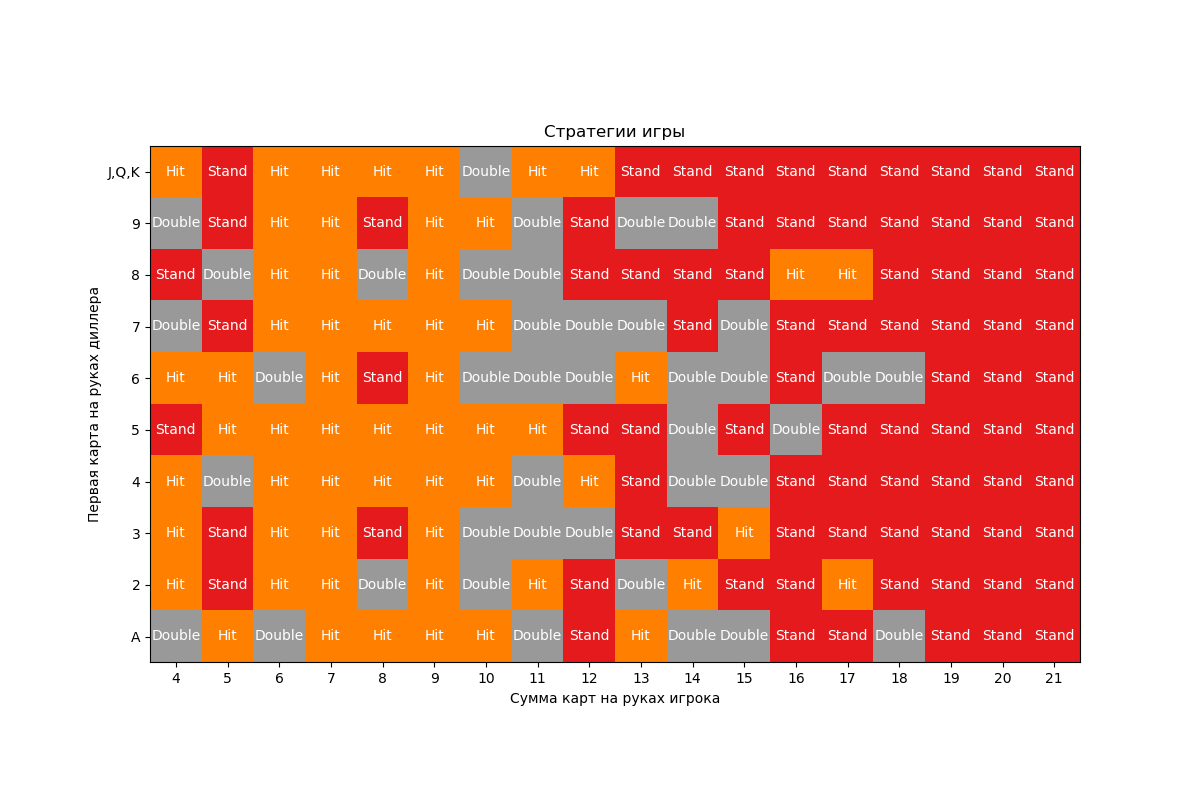

In [31]:
heatmap_plot(data_2, dict_var_2)

## Часть 3. Стратегия с удвоением и подсчетом карт

Обучение модели с возможностью удвоения и подсчётом карт (738 состояний, 3 действия)

In [46]:
model_3 = СountingModel(multiproc_game=False)
ql_3 = QLerning(model_3, alpha=0.1, gamma=0.5, epsilon=0.0)

<IPython.core.display.Javascript object>


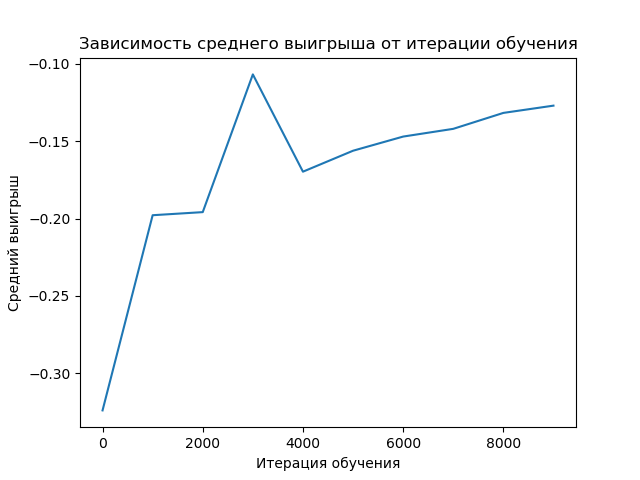

value from best iter = -0.324
value from best iter = -0.1978
value from best iter = -0.1958
value from best iter = -0.10675

all time best= -0.10675


In [47]:
%matplotlib notebook
ql_3.traning_model(n_train = 10000,
                   show_fit = True,
                   delta_show = 1000, 
                   n_games = 10000)

Средний выигрыш на последней итерации обучения

In [48]:
ql_3.get_mean_reward()

-0.12695

Матрица полезности на последней итерации обучения

In [49]:
ql_3.get_matrix_q()

array([[0.68554465, 0.5641181 , 0.42650254],
       [0.57501731, 0.42689425, 0.91684225],
       [0.62744889, 0.85917992, 0.99534715],
       ...,
       [0.23423379, 0.88450966, 0.82152027],
       [0.27652458, 0.32585442, 0.04054757],
       [0.31229176, 0.8152574 , 0.02465278]])

In [78]:
dict_var_3 = {"x_data_labels":list(map(str, np.arange(4, 22))),
              "y_data_labels":list(map(str, np.arange(-20, 21))),
              "figsize":(20,20),
              "title":"Стратегии игры",
              "xlabel":"Сумма карт на руках игрока",
              "ylabel":"Счёт колоды",
             }

Получение матрицы полезности

In [79]:
data_3 = model_3.get_matrix_actions(ql_3.get_matrix_q(), num_col = 18)

Интерпретация матрицы полезности

<IPython.core.display.Javascript object>


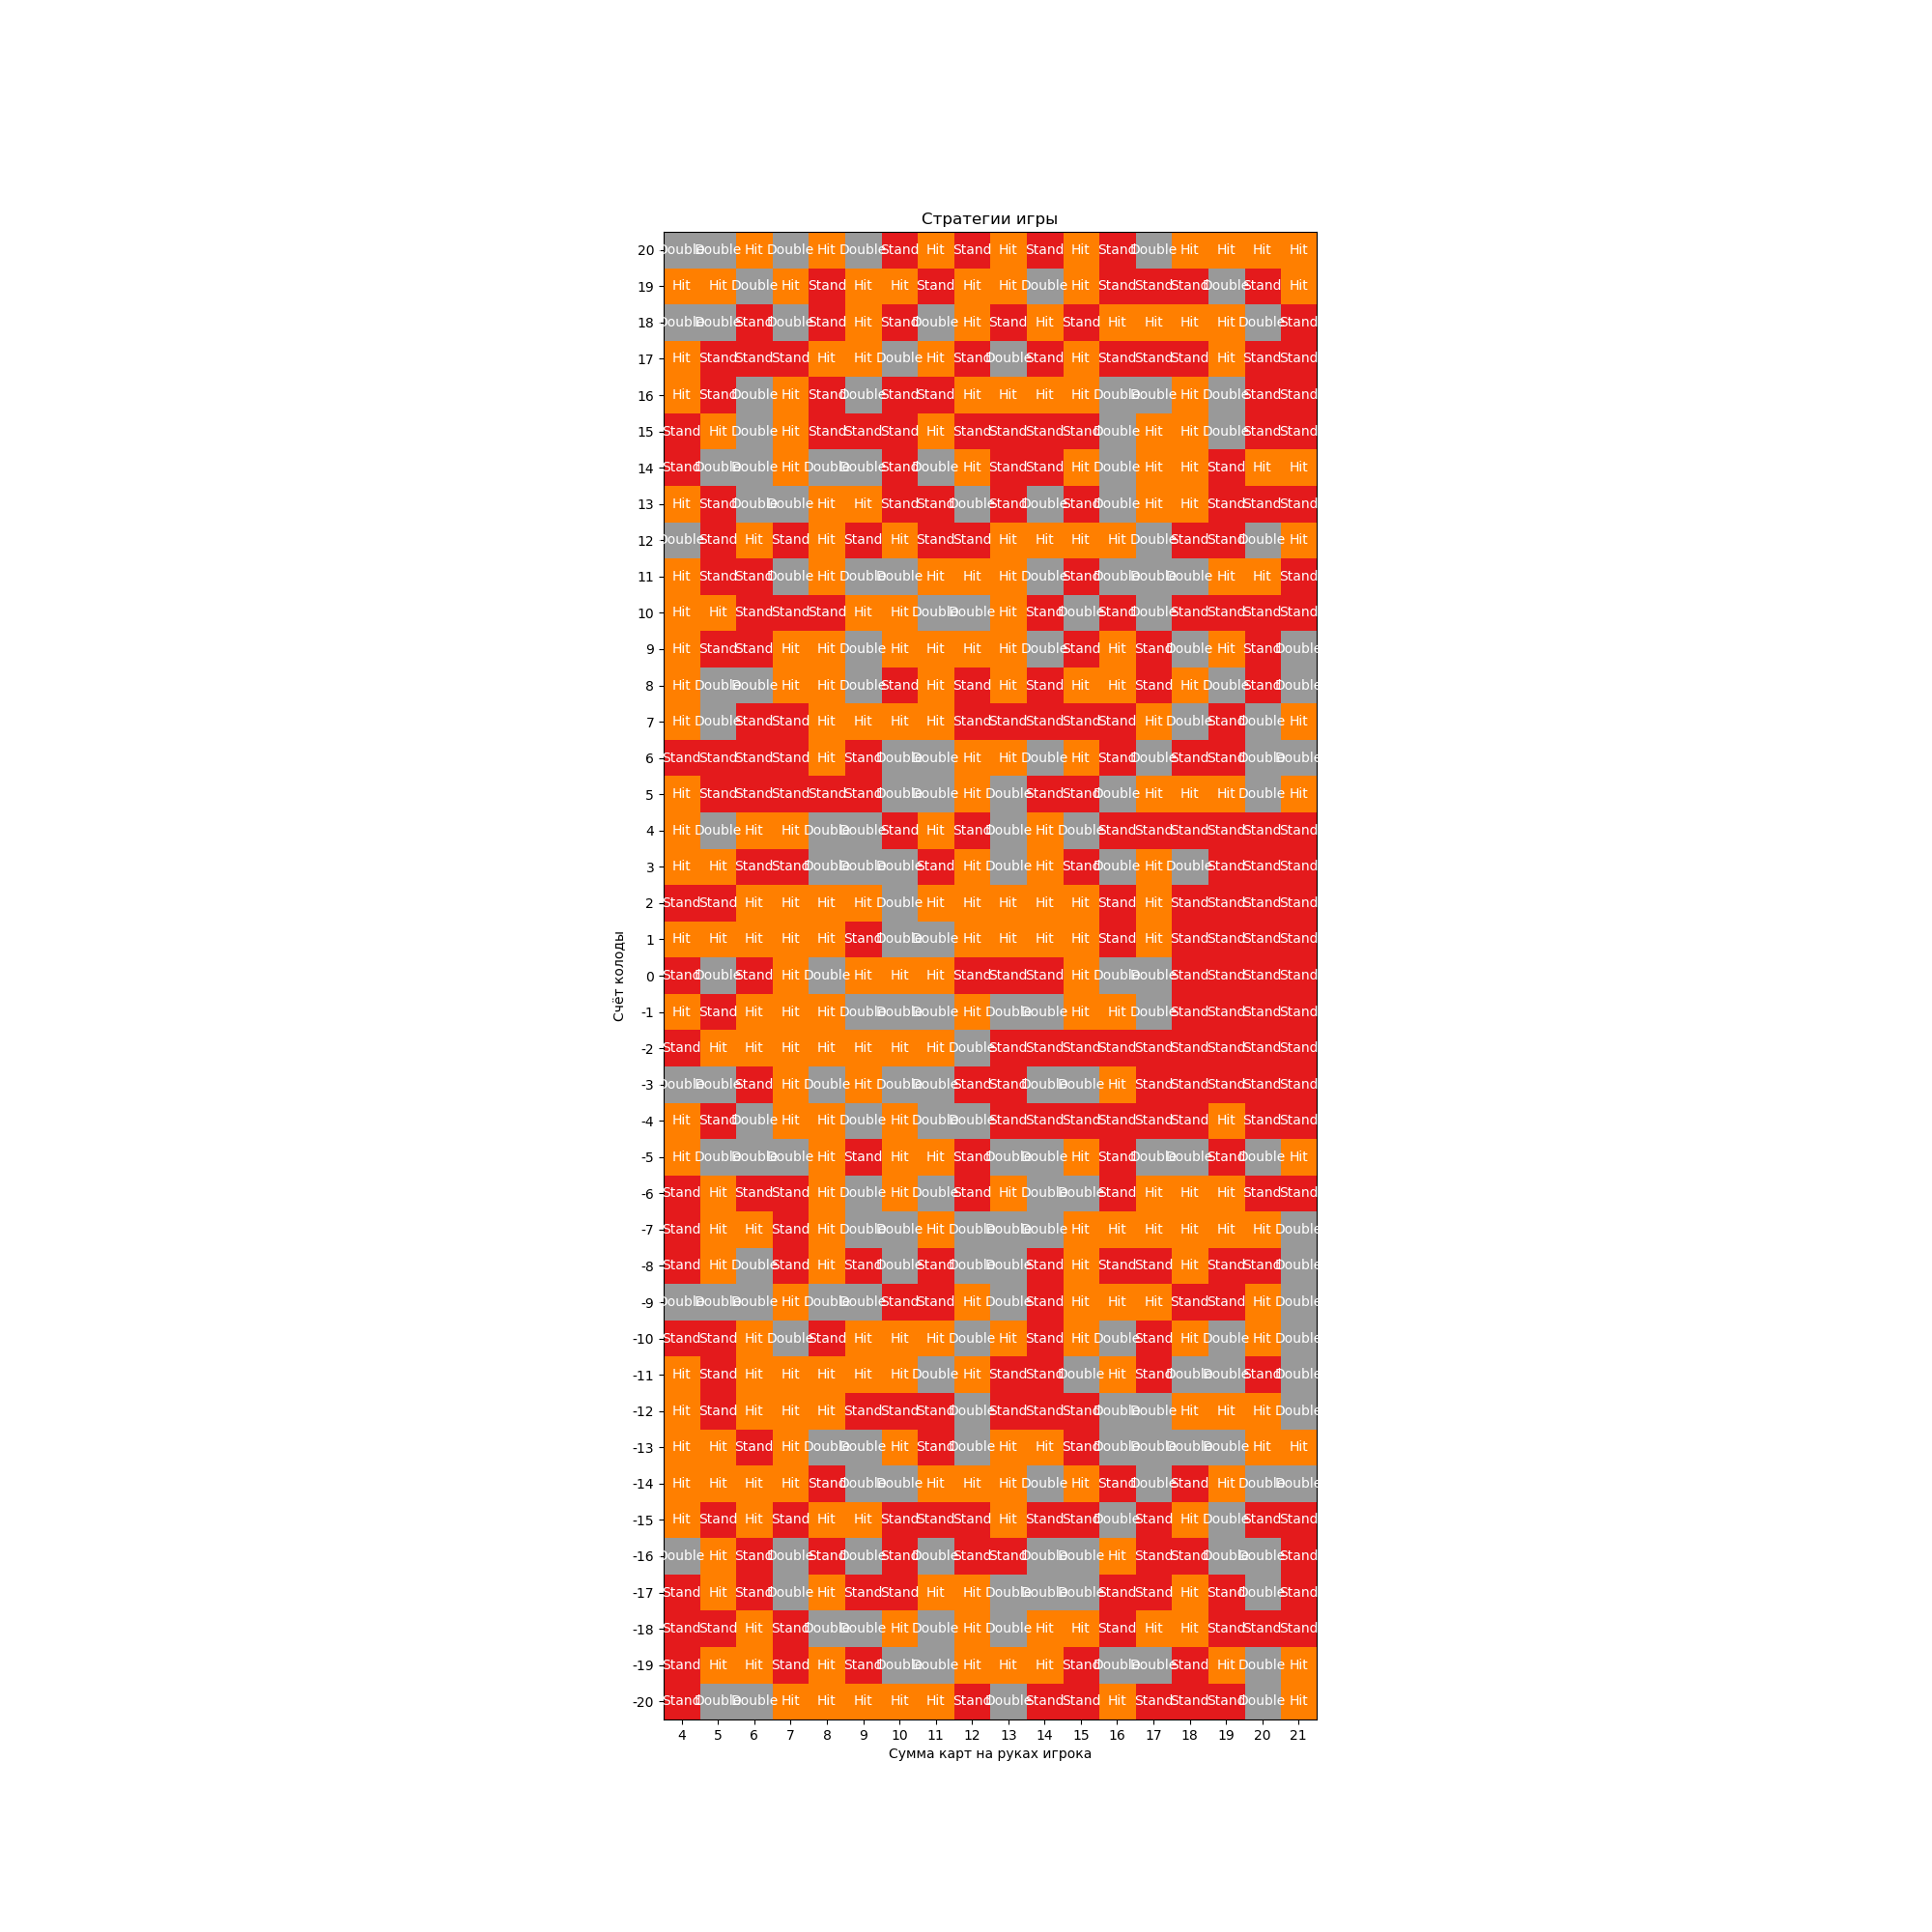

In [80]:
heatmap_plot(data_3, dict_var_3)